# Prediction of time series with different neural networks architectures

In this notebook we will use different network architectures to predict the next steps for a time series. We compare: 

* 1D causal convolutional networks 
* 1D causal convolutional networks witho dilation rate
* RNNs  
* LSTMs

We forecast a time series for longer times than we trained them on and compare the results of the different architectures. The goal is to capture the longterm dependencies of the time series.


In [30]:
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
    %tensorflow_version 2.x
except:
    IN_COLAB = False

In [31]:
# load required libraries:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow.keras as keras
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Lambda, Convolution1D, LSTM, SimpleRNN


## Simulate some data

We produce training data with two different time scales and a bit of noise. This produces 1000 curves which all follow the same pattern: a fast changing sine wave where the amplitude is modulated by a sine wave with lower frequency. To make it a bit more challenging, we add some noise at each timestep of the waves. All of the 1000 waves have the same pattern, however, the starting point is randomly shifted in time. One such example is shown the plot below. The first 128 data points are used as an input to the model (shown as a line). The model should predict the following 10 data points (shown as points). Note that the future data does not follow a smooth curve, but instead is ragged because of the random noise present in the data.

(128,)
(10,)
(128,)
(10,)
(128,)
(10,)
(1000, 128, 1)
[ 0.7455389   0.68002416  0.33028677  0.06922018 -0.04939921 -0.54866364
 -0.45975249 -0.60983968 -0.43943144 -0.26504637]


C:\Users\Maxim\AppData\Local\Temp\ipykernel_15744\1430960787.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(range(seq_length, seq_length + look_ahead),Y[i,:,0],'bo',color='orange')
C:\Users\Maxim\AppData\Local\Temp\ipykernel_15744\1430960787.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(range(seq_length, seq_length + look_ahead),Y[i,:,0],'bo',color='orange')
C:\Users\Maxim\AppData\Local\Temp\ipykernel_15744\1430960787.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(range(seq_length, seq_length + look_ahead),Y[i,:,0],'bo',color='orange')


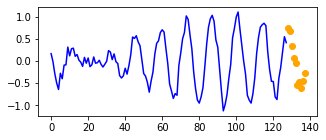

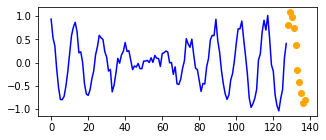

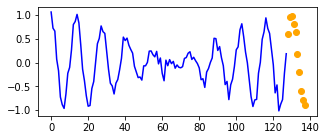

The training data X (solid) line and the next predictions Y (dotted), which should be forecasted.


In [32]:
np.random.seed(1) # Fixing the seed, so that data is always the same
seq_length = 128  # Sequence length used for training
look_ahead =  10  # The number of data points the model should predict 


def gen_data(size=1000, noise=0.1): # We create 1000 data-points
  s = seq_length + look_ahead
  d = np.zeros((size, s,1))
  for i in range(size):
    start = np.random.uniform(0, 2*np.pi) # Random start point
    d[i,:,0] = np.sin(start + np.linspace(0, 20*np.pi, s)) * np.sin(start + np.linspace(0, np.pi, s)) + np.random.normal(0,noise,s)
  return d[:,0:seq_length], d[:,seq_length:s]


X,Y = gen_data()
for i in range(3):
  print(X[i,:,0].shape)
  print(Y[i,:,0].shape)
  plt.figure(num=None, figsize=(5,2))  
  plt.plot(range(0, seq_length),X[i,:,0],'b-')
  plt.plot(range(seq_length, seq_length + look_ahead),Y[i,:,0],'bo',color='orange')

print(X.shape)
print(Y[0,:,0])
plt.show()
print('The training data X (solid) line and the next predictions Y (dotted), which should be forecasted.')

## A) 1D Convolution without dilation rate

### Build network
Here we define a Neural network with 1D convolutions and "causal" padding. 

Build a first model using the causal convolutions. Don't specify the sequence length (batch_input_shape=(None, None, 1)), so you can use a different sequence length in prediction later. The network should have 4, 1-dimensional convolutional layers, with a kernelsize of `ks=5` and 32 feartures. Use the keras function `Convolution1D` for that. The network should report 10 values that the end. You can achive this with the function.

```{pyhon}
def slice(x, slice_length):
    return x[:,-slice_length:,:]
...
model1.add(Lambda(slice, arguments={'slice_length':look_ahead}))
```

Which you add at the end of the network.

Use the first 800 sequences for training and the last 200 for validation. As loss function we use the mean squared error (MSE). You should get a MSE of approx 0.02 to 0.03.

In [33]:

def slice(x, slice_length):
    return x[:,-slice_length:,:]

model1 = keras.Sequential()

# Layers
model1.add(Convolution1D(32, kernel_size=5, batch_input_shape=(None, None, 1), padding="causal"))

model1.add(Convolution1D(32, kernel_size=5, padding="causal"))

model1.add(Convolution1D(32, kernel_size=5, padding="causal"))

model1.add(Convolution1D(32, kernel_size=5, padding="causal"))

model1.add(Dense(1))

model1.add(Lambda(slice, arguments={'slice_length':look_ahead}))

# Model
model1.compile(loss="mean_squared_error")

model1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, None, 32)          192       
                                                                 
 conv1d_13 (Conv1D)          (None, None, 32)          5152      
                                                                 
 conv1d_14 (Conv1D)          (None, None, 32)          5152      
                                                                 
 conv1d_15 (Conv1D)          (None, None, 32)          5152      
                                                                 
 dense_3 (Dense)             (None, None, 1)           33        
                                                                 
 lambda_3 (Lambda)           (None, None, 1)           0         
                                                                 
Total params: 15,681
Trainable params: 15,681
Non-trai

Epoch 1/40
25/25 [==============================] - 1s 12ms/step - loss: 0.0634 - val_loss: 0.0306
Epoch 2/40
25/25 [==============================] - 0s 8ms/step - loss: 0.0403 - val_loss: 0.0291
Epoch 3/40
25/25 [==============================] - 0s 9ms/step - loss: 0.0378 - val_loss: 0.0264
Epoch 4/40
25/25 [==============================] - 0s 9ms/step - loss: 0.0335 - val_loss: 0.0319
Epoch 5/40
25/25 [==============================] - 0s 9ms/step - loss: 0.0340 - val_loss: 0.0262
Epoch 6/40
25/25 [==============================] - 0s 9ms/step - loss: 0.0306 - val_loss: 0.0308
Epoch 7/40
25/25 [==============================] - 0s 9ms/step - loss: 0.0329 - val_loss: 0.0328
Epoch 8/40
25/25 [==============================] - 0s 9ms/step - loss: 0.0307 - val_loss: 0.0263
Epoch 9/40
25/25 [==============================] - 0s 9ms/step - loss: 0.0307 - val_loss: 0.0299
Epoch 10/40
25/25 [==============================] - 0s 9ms/step - loss: 0.0301 - val_loss: 0.0246
Epoch 11/40
25/25 

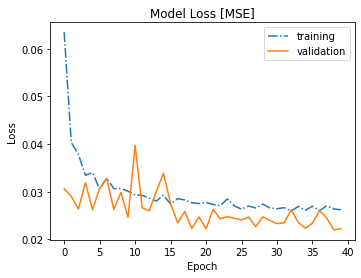

In [34]:
X_train = X[:799]
Y_train = Y[:799]
X_valid = X[800:]
Y_valid = Y[800:]

history = model1.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), epochs=40)

# Plot
plt.figure(figsize=(12,4))

plt.subplot(1,2,(2))
plt.plot(history.history['loss'], linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('Model Loss [MSE]')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')

### Make repeated predictions



Since we work with simulated data, we can produce as much new data as we like. We can also switch off the noise and check how well the model can extract the real underlying pattern in the data.

In [35]:
x_test,y_test = gen_data(size=1,noise=0.0)
print(x_test.shape)
print(y_test.shape)
model1.predict(x_test).reshape(-1)#Predicts 10 value

(1, 128, 1)
(1, 10, 1)


array([ 0.87362295,  0.7940375 ,  0.5618076 ,  0.22828321, -0.13537903,
       -0.45352247, -0.6618793 , -0.720676  , -0.6222565 , -0.3917556 ],
      dtype=float32)

Write a function which predicts 10 values from a starting sequence of size 128. Then add these predicted values to the starting sequence and uses this sequence of length 138 as a new starting sequence. Repeat this procedure 12 times. You should get a prediction for 120 time points in the future.  

In [36]:
x_test,y_test = gen_data(size=1,noise=0.0)
def predict(sequence):
    pred = model1.predict(sequence)
    new_sequence = np.append(sequence, pred)
    new_sequence = new_sequence.reshape((1,len(new_sequence),1))
    return new_sequence

y_pred = predict(x_test)
for x in range(11):
    y_pred = predict(y_pred)

# Remove data which is already in x_test
y_pred = y_pred[:,128:]

print(x_test.shape)
print(y_pred.shape)

(1, 128, 1)
(1, 120, 1)


C:\Users\Maxim\AppData\Local\Temp\ipykernel_15744\341262184.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(range(128, 248),y_pred[0,:,0],'bo',color='orange')


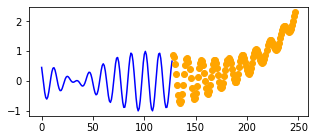

The training data X (solid) line and the next predictions Y (dotted), which should be forecasted.


In [37]:

plt.figure(num=None, figsize=(5,2))  
plt.plot(range(0, 128),x_test[0,:,0],'b-')
plt.plot(range(128, 248),y_pred[0,:,0],'bo',color='orange')

plt.show()
print('The training data X (solid) line and the next predictions Y (dotted), which should be forecasted.')

## B) 1D Convolution with dilation rate


Here we define a Neural network with 1D convolutions and "causal" padding, this time with dilation rate, so we are able to look back longer in time (see figure below)
 
![](https://i.stack.imgur.com/20xRe.png)

Build the same network as in A) but this time with dilation_rates 1,2,4,8 

In [38]:

def slice(x, slice_length):
    return x[:,-slice_length:,:]

model2 = keras.Sequential()

# Layers
model2.add(Convolution1D(32, kernel_size=5, batch_input_shape=(None, None, 1), padding="causal", dilation_rate=1))

model2.add(Convolution1D(32, kernel_size=5, padding="causal", dilation_rate=2))

model2.add(Convolution1D(32, kernel_size=5, padding="causal", dilation_rate=4))

model2.add(Convolution1D(32, kernel_size=5, padding="causal",dilation_rate=8))

model2.add(Dense(1))

model2.add(Lambda(slice, arguments={'slice_length':look_ahead}))

# Model
model2.compile(loss="mean_squared_error")

model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_16 (Conv1D)          (None, None, 32)          192       
                                                                 
 conv1d_17 (Conv1D)          (None, None, 32)          5152      
                                                                 
 conv1d_18 (Conv1D)          (None, None, 32)          5152      
                                                                 
 conv1d_19 (Conv1D)          (None, None, 32)          5152      
                                                                 
 dense_4 (Dense)             (None, None, 1)           33        
                                                                 
 lambda_4 (Lambda)           (None, None, 1)           0         
                                                                 
Total params: 15,681
Trainable params: 15,681
Non-trai

Epoch 1/40
25/25 [==============================] - 1s 14ms/step - loss: 0.0604 - val_loss: 0.0217
Epoch 2/40
25/25 [==============================] - 0s 10ms/step - loss: 0.0266 - val_loss: 0.0141
Epoch 3/40
25/25 [==============================] - 0s 10ms/step - loss: 0.0227 - val_loss: 0.0176
Epoch 4/40
25/25 [==============================] - 0s 10ms/step - loss: 0.0216 - val_loss: 0.0147
Epoch 5/40
25/25 [==============================] - 0s 11ms/step - loss: 0.0199 - val_loss: 0.0117
Epoch 6/40
25/25 [==============================] - 0s 10ms/step - loss: 0.0203 - val_loss: 0.0142
Epoch 7/40
25/25 [==============================] - 0s 10ms/step - loss: 0.0183 - val_loss: 0.0131
Epoch 8/40
25/25 [==============================] - 0s 10ms/step - loss: 0.0178 - val_loss: 0.0142
Epoch 9/40
25/25 [==============================] - 0s 11ms/step - loss: 0.0177 - val_loss: 0.0391
Epoch 10/40
25/25 [==============================] - 0s 10ms/step - loss: 0.0184 - val_loss: 0.0143
Epoch 11/

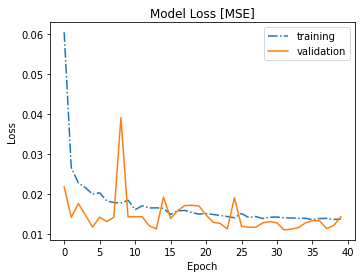

In [39]:
X_train = X[:799]
Y_train = Y[:799]
X_valid = X[800:]
Y_valid = Y[800:]

history = model2.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), epochs=40)

# Plot
plt.figure(figsize=(12,4))

plt.subplot(1,2,(2))
plt.plot(history.history['loss'], linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('Model Loss [MSE]')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')

### Make repeated predictions
As in A) make preaded preditions on noise less data.

In [40]:
x_test,y_test = gen_data(size=1,noise=0.0)
print(x_test.shape)
print(y_test.shape)
model2.predict(x_test).reshape(-1)#Predicts 10 value

(1, 128, 1)
(1, 10, 1)


array([-0.08698881, -0.03923856,  0.03680925,  0.12495446,  0.20290354,
        0.24775831,  0.24219105,  0.17971648,  0.06761539, -0.07342663],
      dtype=float32)

In [105]:
x_test,y_test = gen_data(size=1,noise=0.0)
def predict(sequence):
    pred = model2.predict(sequence)
    new_sequence = np.append(sequence, pred)
    new_sequence = new_sequence.reshape((1,len(new_sequence),1))
    return new_sequence

y_pred = predict(x_test)
for x in range(11):
    y_pred = predict(y_pred)

# Remove data which is already in x_test
y_pred = y_pred[:,128:]

print(x_test.shape)
print(y_pred.shape)

(1, 138, 1)
(1, 128, 1)
(1, 120, 1)


C:\Users\Maxim\AppData\Local\Temp\ipykernel_15744\341262184.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(range(128, 248),y_pred[0,:,0],'bo',color='orange')


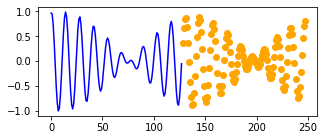

The training data X (solid) line and the next predictions Y (dotted), which should be forecasted.


In [42]:

plt.figure(num=None, figsize=(5,2))  
plt.plot(range(0, 128),x_test[0,:,0],'b-')
plt.plot(range(128, 248),y_pred[0,:,0],'bo',color='orange')

plt.show()
print('The training data X (solid) line and the next predictions Y (dotted), which should be forecasted.')

## C) Simple RNN

Now, use a RNN cell Keras `SimpleRNN` to see if we are able to learn the data generating process. Start with a hidden state size of 12. Repeat the task from A) and B). Consider to add several layers of cells and play with the state size.

In [119]:
def create_RNN(hidden_units, dense_units, input_shape, activation):
    new_model = Sequential()
    new_model.add(SimpleRNN(hidden_units, input_shape= input_shape,
                        activation=activation[0], return_sequences=True))
    new_model.add(SimpleRNN(hidden_units, input_shape= input_shape,
                        activation=activation[0], return_sequences=True))
    new_model.add(SimpleRNN(hidden_units, input_shape= input_shape,
                        activation=activation[0], return_sequences=True))
    new_model.add(Dense(units=dense_units, activation=activation[1]))
    new_model.add(Lambda(slice, arguments={'slice_length':look_ahead}))
    new_model.compile(loss='mean_squared_error', optimizer='adam')
    return new_model

model3 = create_RNN(48, 1, (None,1), activation=['tanh', 'tanh'])

model3.summary()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_82 (SimpleRNN)   (None, None, 48)          2400      
                                                                 
 simple_rnn_83 (SimpleRNN)   (None, None, 48)          4656      
                                                                 
 simple_rnn_84 (SimpleRNN)   (None, None, 48)          4656      
                                                                 
 dense_34 (Dense)            (None, None, 1)           49        
                                                                 
 lambda_9 (Lambda)           (None, None, 1)           0         
                                                                 
Total params: 11,761
Trainable params: 11,761
Non-trainable params: 0
_________________________________________________________________


Epoch 1/40
25/25 [==============================] - 2s 46ms/step - loss: 0.0963 - val_loss: 0.0278
Epoch 2/40
25/25 [==============================] - 1s 37ms/step - loss: 0.0261 - val_loss: 0.0197
Epoch 3/40
25/25 [==============================] - 1s 37ms/step - loss: 0.0198 - val_loss: 0.0157
Epoch 4/40
25/25 [==============================] - 1s 37ms/step - loss: 0.0174 - val_loss: 0.0163
Epoch 5/40
25/25 [==============================] - 1s 37ms/step - loss: 0.0166 - val_loss: 0.0141
Epoch 6/40
25/25 [==============================] - 1s 38ms/step - loss: 0.0149 - val_loss: 0.0134
Epoch 7/40
25/25 [==============================] - 1s 38ms/step - loss: 0.0142 - val_loss: 0.0129
Epoch 8/40
25/25 [==============================] - 1s 37ms/step - loss: 0.0138 - val_loss: 0.0120
Epoch 9/40
25/25 [==============================] - 1s 37ms/step - loss: 0.0136 - val_loss: 0.0120
Epoch 10/40
25/25 [==============================] - 1s 37ms/step - loss: 0.0137 - val_loss: 0.0124
Epoch 11/

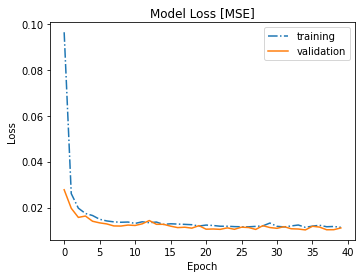

In [120]:
X_train = X[:799]
Y_train = Y[:799]
X_valid = X[800:]
Y_valid = Y[800:]

history = model3.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), epochs=40)

# Plot
plt.figure(figsize=(12,4))

plt.subplot(1,2,(2))
plt.plot(history.history['loss'], linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('Model Loss [MSE]')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')

In [121]:
x_test,y_test = gen_data(size=1,noise=0.0)
print(x_test.shape)
print(y_test.shape)
model3.predict(x_test).reshape(-1)#Predicts 10 value

(1, 128, 1)
(1, 10, 1)


array([ 0.46236235,  0.7788692 ,  0.9321737 ,  0.9202184 ,  0.7230806 ,
        0.37519923, -0.05535239, -0.49180087, -0.82070947, -0.93580073],
      dtype=float32)

### Make repeated predictions
As in A) make preaded preditions on noise less data.

In [124]:
x_test,y_test = gen_data(size=1,noise=0.0)
def predict(sequence):
    pred = model3.predict(sequence)
    new_sequence = np.append(sequence, pred)
    new_sequence = new_sequence.reshape((1,len(new_sequence),1))
    return new_sequence

y_pred = predict(x_test)
for x in range(11):
    y_pred = predict(y_pred)

# Remove data which is already in x_test
y_pred = y_pred[:,128:]

print(x_test.shape)
print(y_pred.shape)

(1, 128, 1)
(1, 120, 1)


C:\Users\Maxim\AppData\Local\Temp\ipykernel_15744\1013941086.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(range(128, 248),y_pred[0,:,0],'bo',color='orange')


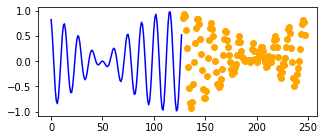

The training data X (solid) line and the next predictions Y (dotted), which should be forecasted.


In [123]:
plt.figure(num=None, figsize=(5,2))
plt.plot(range(0, 128),x_test[0,:,0],'b-')
plt.plot(range(128, 248),y_pred[0,:,0],'bo',color='orange')

plt.show()
print('The training data X (solid) line and the next predictions Y (dotted), which should be forecasted.')

## D) LSTM Cell
Repeat C) but now with an LSTM cell.

In [126]:
def create_LSTM(hidden_units, dense_units, input_shape, activation):
    new_model = Sequential()
    new_model.add(LSTM(hidden_units, input_shape= input_shape,
                        activation=activation[0], return_sequences=True))
    new_model.add(LSTM(hidden_units, input_shape= input_shape,
                        activation=activation[0], return_sequences=True))
    new_model.add(LSTM(hidden_units, input_shape= input_shape,
                        activation=activation[0], return_sequences=True))
    new_model.add(Dense(units=dense_units, activation=activation[1]))
    new_model.add(Lambda(slice, arguments={'slice_length':look_ahead}))
    new_model.compile(loss='mean_squared_error', optimizer='adam')
    return new_model

model4 = create_LSTM(48, 1, (None,1), activation=['tanh', 'tanh'])

model4.summary()

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, None, 48)          9600      
                                                                 
 lstm_4 (LSTM)               (None, None, 48)          18624     
                                                                 
 lstm_5 (LSTM)               (None, None, 48)          18624     
                                                                 
 dense_36 (Dense)            (None, None, 1)           49        
                                                                 
 lambda_11 (Lambda)          (None, None, 1)           0         
                                                                 
Total params: 46,897
Trainable params: 46,897
Non-trainable params: 0
_________________________________________________________________


Epoch 1/40
25/25 [==============================] - 6s 110ms/step - loss: 0.1960 - val_loss: 0.0442
Epoch 2/40
25/25 [==============================] - 2s 87ms/step - loss: 0.0485 - val_loss: 0.0386
Epoch 3/40
25/25 [==============================] - 2s 89ms/step - loss: 0.0380 - val_loss: 0.0340
Epoch 4/40
25/25 [==============================] - 2s 87ms/step - loss: 0.0350 - val_loss: 0.0328
Epoch 5/40
25/25 [==============================] - 2s 89ms/step - loss: 0.0333 - val_loss: 0.0308
Epoch 6/40
25/25 [==============================] - 2s 88ms/step - loss: 0.0320 - val_loss: 0.0298
Epoch 7/40
25/25 [==============================] - 2s 90ms/step - loss: 0.0312 - val_loss: 0.0293
Epoch 8/40
25/25 [==============================] - 2s 89ms/step - loss: 0.0297 - val_loss: 0.0260
Epoch 9/40
25/25 [==============================] - 2s 89ms/step - loss: 0.0228 - val_loss: 0.0214
Epoch 10/40
25/25 [==============================] - 2s 89ms/step - loss: 0.0209 - val_loss: 0.0195
Epoch 11

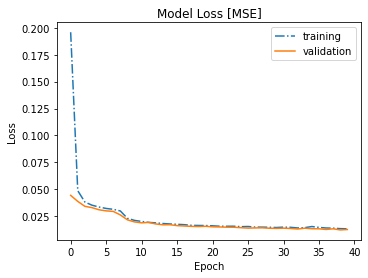

In [127]:
X_train = X[:799]
Y_train = Y[:799]
X_valid = X[800:]
Y_valid = Y[800:]

history = model4.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), epochs=40)

# Plot
plt.figure(figsize=(12,4))

plt.subplot(1,2,(2))
plt.plot(history.history['loss'], linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('Model Loss [MSE]')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper right')

In [128]:
x_test,y_test = gen_data(size=1,noise=0.0)
print(x_test.shape)
print(y_test.shape)
model3.predict(x_test).reshape(-1)#Predicts 10 value

(1, 128, 1)
(1, 10, 1)


array([-0.00564395, -0.00593079, -0.00531351, -0.00396229, -0.00216847,
       -0.00029295,  0.00130049,  0.00232072,  0.00261448,  0.00219742],
      dtype=float32)

In [130]:
x_test,y_test = gen_data(size=1,noise=0.0)
def predict(sequence):
    pred = model4.predict(sequence)
    new_sequence = np.append(sequence, pred)
    new_sequence = new_sequence.reshape((1,len(new_sequence),1))
    return new_sequence

y_pred = predict(x_test)
for x in range(11):
    y_pred = predict(y_pred)

# Remove data which is already in x_test
y_pred = y_pred[:,128:]

print(x_test.shape)
print(y_pred.shape)

(1, 128, 1)
(1, 120, 1)


C:\Users\Maxim\AppData\Local\Temp\ipykernel_15744\4277386433.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(range(128, 248),y_pred[0,:,0],'bo',color='orange')


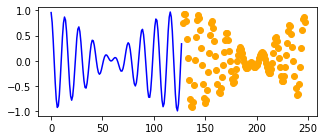

The training data X (solid) line and the next predictions Y (dotted), which should be forecasted.


In [131]:
plt.figure(num=None, figsize=(5,2))
plt.plot(range(0, 128),x_test[0,:,0],'b-')
plt.plot(range(128, 248),y_pred[0,:,0],'bo',color='orange')

plt.show()
print('The training data X (solid) line and the next predictions Y (dotted), which should be forecasted.')